In [6]:
#认证
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmp_nhur5d2/pubring.gpg' created
gpg: /tmp/tmp_nhur5d2/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [0]:
#挂载云盘
!mkdir -p drive
!google-drive-ocamlfuse drive  -o nonempty

In [8]:
!pip install xgboost
import xgboost as xgb
import pandas as pd
import numpy as np

In [30]:
#读取数据
train_csv = pd.read_csv("drive/Colab_Notebooks/data/round1_ijcai_18_train_20180301.txt"," ")
test_csv = pd.read_csv("drive/Colab_Notebooks/data/round1_ijcai_18_test_a_20180301.txt"," ")
print(len(train_csv),len(test_csv))

478138 18371


In [38]:
train_pd = train_csv.drop_duplicates("instance_id").copy()
test_pd = test_csv.drop_duplicates("instance_id").copy()
print(len(train_csv),len(test_csv))

478138 18371


In [78]:
#补充时间数据
import time
train_pd['day']=train_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
train_pd['hour']=train_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))
test_pd['day']=test_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
test_pd['hour']=test_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))
#展示列名
print("columns length:",len(train_pd.columns))
print("列名：",train_pd.columns)
#时间列
train_time_list = sorted(train_pd["day"].unique())
print("时间序列：",train_time_list)

columns length: 54
列名： Index(['instance_id', 'item_id', 'item_category_list', 'item_property_list',
       'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade', 'category_gender_trade_score',
       'brand_total_ratio', 'brand_trade_ratio', 'city_total_ratio',
       'city_trade_ratio', 'price_total_ratio', 'price_trade_ratio',
       'sales_total_ratio', 'sales_trade_ratio', 'collected_total_ratio',
       'collected_trade_ratio', 'pv_total_ratio', 'pv_trade_ratio',
       'age_total_ratio', 'age_trade_ratio', 'occupation_total_ratio',
       'occupatio

# 简单数据统计

## 基本数据统计

In [7]:
print('总样本个数:%d' % train_csv.instance_id.unique().shape[0])
print('当前正样本个数为： %d' % len(train_csv[train_csv.is_trade == 1]))
print('当前负样本个数为： %d' % len(train_csv[train_csv.is_trade == 0]))
print('当前商品个数:%d' % train_csv.item_id.unique().shape[0])
print('用户数量：%d' % train_csv.user_id.unique().shape[0])
print('商户数量：%d' % train_csv.shop_id.unique().shape[0])
print('商标数量：%d' % train_csv.item_brand_id.unique().shape[0])
print('广告最大等级为：%d' % max(train_csv['item_price_level']))
print('最大广告销量等级：%d' % max(train_csv['item_sales_level']))
print('最大广告收藏等级:%d' % max(train_csv['item_collected_level']))
print('最大浏览量等级:%d' % max(train_csv['item_pv_level']))
print('用户的预测年龄等级区间为 %d-%d' % (min(train_csv['user_age_level']),max(train_csv['user_age_level'])))
print('用户等级区间为%d-%d' % (min(train_csv['user_star_level']), max(train_csv['user_star_level'])))
print('最大店铺评价数量等级:%d' % max(train_csv['shop_review_num_level']))
print('最大店铺星级编号:%d' % max(train_csv['shop_star_level']))

总样本个数:478087
当前正样本个数为： 8994
当前负样本个数为： 469093
当前商品个数:10075
用户数量：197685
商户数量：3959
商标数量：2055
广告最大等级为：17
最大广告销量等级：17
最大广告收藏等级:17
最大浏览量等级:21
用户的预测年龄等级区间为 -1-1007
用户等级区间为-1-3010
最大店铺评价数量等级:25
最大店铺星级编号:5020


In [9]:
%%time
import time
train_csv['day']=train_csv.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
train_csv['hour']=train_csv.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))

CPU times: user 1.53 s, sys: 33 ms, total: 1.57 s
Wall time: 1.57 s


每天行为数量
2018-09-18    78261
2018-09-19    70926
2018-09-20    68377
2018-09-21    71193
2018-09-22    68309
2018-09-23    63610
2018-09-24    57411
Name: day, dtype: int64


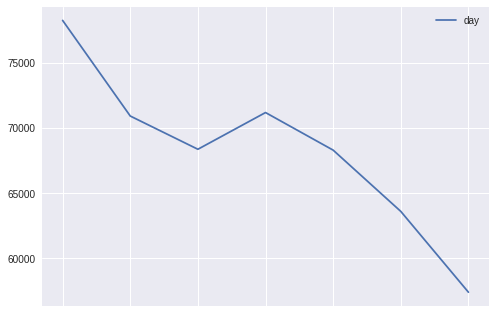

In [10]:
print('每天行为数量')
print(train_csv.day.value_counts().sort_index())
pd.DataFrame(train_csv.day.value_counts().sort_index()).plot()

## item_category_list的统计信息

item_category_list分割后长度最小值： 2  长度最大值： 3


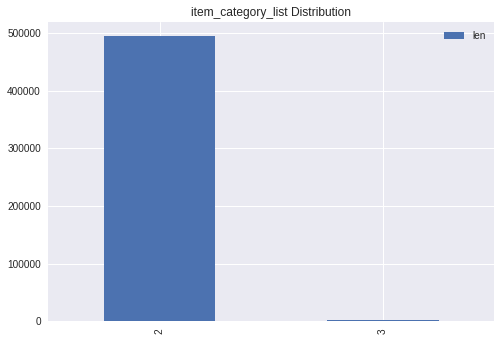

In [10]:
all_data = [train_csv,test_csv]
all_data = pd.concat(all_data)
category_list= list(map(lambda x:len(x.split(";")),all_data["item_category_list"]))
item_category_list = pd.DataFrame({"len":category_list,"list":list(map(lambda x:x.split(";"),all_data["item_category_list"]))})
print("item_category_list分割后长度最小值：",item_category_list["len"].min()," 长度最大值：",item_category_list["len"].max())
pd.DataFrame(item_category_list["len"].value_counts().sort_index()).plot(kind="bar",title="item_category_list Distribution")

## item_property_list的统计信息

item_category_list分割后长度最小值： 6  长度最大值： 100


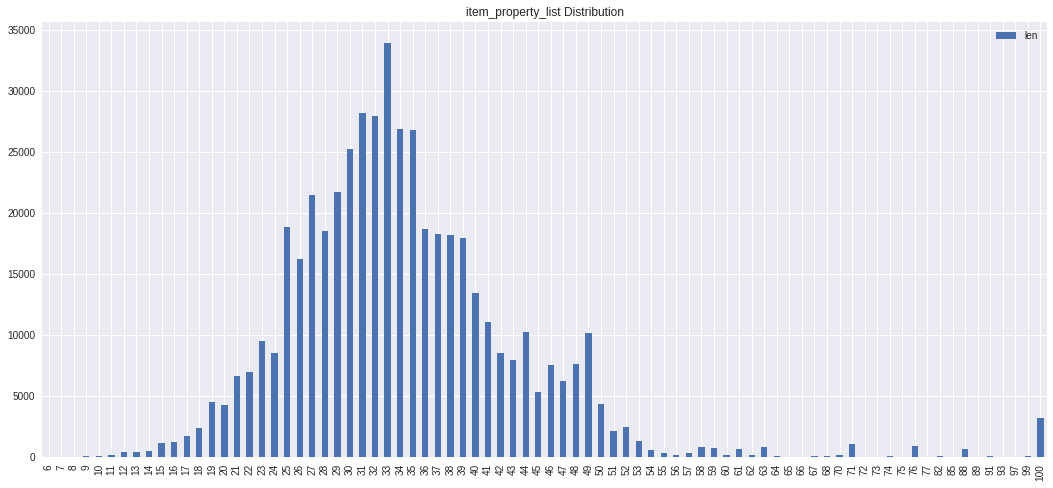

In [6]:
all_data = [train_csv,test_csv]
all_data = pd.concat(all_data)
property_list= list(map(lambda x:len(x.split(";")),all_data["item_property_list"]))
item_property_list = pd.DataFrame({"len":property_list,"list":list(map(lambda x:x.split(";"),all_data["item_property_list"]))})
print("item_category_list分割后长度最小值：",item_property_list["len"].min()," 长度最大值：",item_property_list["len"].max())
pd.DataFrame(item_property_list["len"].value_counts().sort_index()).plot(kind="bar",title="item_property_list Distribution",figsize=(18,8))

# 计算特征

In [0]:
feature_list=[]#特征列表

## 计算item_category_list所有类别信息对应的is_trade数目z-score
感觉区别度不算大，此特征不一定有太大作用

In [40]:
#传入DataFrame而获取对应category的is_trade数目表
def get_category_trade_score(df):
  temp_pd = df[["instance_id","item_category_list","is_trade","user_gender_id"]].copy()#返回的DataFrame
  #只留第2个category，第一个category都是一样的
  temp_pd["category"] =  list(map(lambda x:x.split(";")[1],temp_pd["item_category_list"]))
  #temp_pd.groupby(["category","user_gender_id"]).count().at[("1968056100269760729",1),"is_trade"]
  ret = temp_pd.groupby(["category","user_gender_id"]).count()
  #ret["trade_ratio"] = ret["is_trade"]/len(df)#trade的比例
  ret["category_gender_trade_score"] = (ret["is_trade"]-ret["is_trade"].mean())/ret["is_trade"].std()#计算z-score
  ret = ret.reset_index()
  ret.set_index(["category","user_gender_id"],inplace=True,drop=False)
  return ret
#设定train和test表数据
def set_category_trade_score(df,score_table):
  ret = df[["instance_id","item_category_list","user_gender_id"]].copy()
  ret["category"] = list(map(lambda x:x.split(";")[1],ret["item_category_list"]))
  ret = pd.merge(ret,score_table,on=["category","user_gender_id"],how="left",suffixes=["","_r"]).fillna(0)[["instance_id","category_gender_trade_score"]].copy()
  df = pd.merge(df,ret,on="instance_id",how="left")
  return df
category_trade_rate = get_category_trade_score(train_pd)
train_pd = set_category_trade_score(train_csv,category_trade_rate)
test_pd = set_category_trade_score(test_csv,category_trade_rate)
print(train_pd.columns)
if "category_gender_trade_score" not in feature_list:
  feature_list.append("category_gender_trade_score")

Index(['instance_id', 'item_id', 'item_category_list', 'item_property_list',
       'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade', 'category_gender_trade_score'],
      dtype='object')


## 计算item_property_list对应的特征

In [0]:
%%time
def get_property_dict(df):
  ret = df[["user_gender_id","item_property_list","is_trade"]].copy()
  #下面这句骚操作把一行扩展成多行
  ret = ret.drop('item_property_list', axis=1).join(ret['item_property_list'].str.split(';', expand=True).stack().reset_index(level=1, drop=True).rename('item_property_list'))
  ret = ret.rename(columns={"item_property_list":"property"})
  ret = ret.groupby(["property","user_gender_id"]).count()
  ret = ret.reset_index()
  ret.set_index(["property","user_gender_id"],inplace=True,drop=False)
  ret["is_trade"] = ret["is_trade"]/ret["is_trade"].max()#归一化
  return ret
#这里怎么用没想好
property_pd = get_property_dict(train_pd)

##计算item_brand_id特征

In [0]:
def get_brand_feature(df):
  ret = df[["item_brand_id","is_trade"]].copy()
  ret = ret.groupby("item_brand_id").sum()
  ret["brand_total_count"] = df.groupby("item_brand_id").count()["is_trade"]
  ret["brand_trade_ratio"] = ret["is_trade"] / ret["brand_total_count"]
  ret["brand_total_ratio"] = ret["brand_total_count"]/ret["brand_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("item_brand_id",inplace=True,drop=False)
  ret = ret[["item_brand_id","brand_total_ratio","brand_trade_ratio"]]
  return ret
def set_brand_feature(df,brand_table):
  df = pd.merge(df,brand_table,on="item_brand_id",how="left")
  return df
brand_pd = get_brand_feature(train_pd)
train_pd = set_brand_feature(train_pd,brand_pd)
test_pd = set_brand_feature(test_pd,brand_pd)
if "brand_total_ratio" not in feature_list:
  feature_list.append("brand_total_ratio")
if "brand_trade_ratio" not in feature_list:
  feature_list.append("brand_trade_ratio")

##计算item_city_id的特征

In [0]:
def get_city_feature(df):
  ret = df[["item_city_id","is_trade"]].copy()
  ret = ret.groupby("item_city_id").sum()
  ret["city_total_count"] = df.groupby("item_city_id").count()["is_trade"]
  ret["city_trade_ratio"] = ret["is_trade"] / ret["city_total_count"]
  ret["city_total_ratio"] = ret["city_total_count"]/ret["city_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("item_city_id",inplace=True,drop=False)
  ret = ret[["item_city_id","city_total_ratio","city_trade_ratio"]]
  return ret
def set_city_feature(df,city_table):
  df = pd.merge(df,city_table,on="item_city_id",how="left")
  return df
city_pd = get_city_feature(train_pd)
train_pd = set_city_feature(train_pd,city_pd)
test_pd = set_city_feature(test_pd,city_pd)
if "city_total_ratio" not in feature_list:
  feature_list.append("city_total_ratio")
if "city_trade_ratio" not in feature_list:
  feature_list.append("city_trade_ratio")
if "item_city_id" not in feature_list:
  feature_list.append("item_city_id")

##计算item_price_level特征

In [0]:
def get_price_feature(df):
  ret = df[["item_price_level","is_trade"]].copy()
  ret = ret.groupby("item_price_level").sum()
  ret["price_total_count"] = df.groupby("item_price_level").count()["is_trade"]
  ret["price_trade_ratio"] = ret["is_trade"] / ret["price_total_count"]
  ret["price_total_ratio"] = ret["price_total_count"] / ret["price_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("item_price_level",inplace=True,drop=False)
  ret = ret[["item_price_level","price_total_ratio","price_trade_ratio"]]
  return ret
def set_price_feature(df,price_table):
  df = pd.merge(df,price_table,on="item_price_level",how="left")
  return df
price_pd = get_price_feature(train_pd)
train_pd = set_price_feature(train_pd,price_pd)
test_pd = set_price_feature(test_pd,price_pd)
if "price_total_ratio" not in feature_list:
  feature_list.append("price_total_ratio")
if "price_trade_ratio" not in feature_list:
  feature_list.append("price_trade_ratio")
if "item_price_level" not in feature_list:
  feature_list.append("item_price_level")

##计算item_sales_level的特征

In [0]:
def get_sales_feature(df):
  ret = df[["item_sales_level","is_trade"]].copy()
  ret = ret.groupby("item_sales_level").sum()
  ret["sales_total_count"] = df.groupby("item_sales_level").count()["is_trade"]
  ret["sales_trade_ratio"] = ret["is_trade"] / ret["sales_total_count"]
  ret["sales_total_ratio"] = ret["sales_total_count"] / ret["sales_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("item_sales_level",inplace=True,drop=False)
  ret = ret[["item_sales_level","sales_total_ratio","sales_trade_ratio"]]
  return ret
def set_sales_feature(df,sales_table):
  df = pd.merge(df,sales_table,on="item_sales_level",how="left")
  return df
sales_pd = get_sales_feature(train_pd)
train_pd = set_sales_feature(train_pd,sales_pd)
test_pd = set_sales_feature(test_pd,sales_pd)
if "sales_total_ratio" not in feature_list:
  feature_list.append("sales_total_ratio")
if "sales_trade_ratio" not in feature_list:
  feature_list.append("sales_trade_ratio")
if "item_sales_level" not in feature_list:
  feature_list.append("item_sales_level")

##计算item_collected_level的特征

In [0]:
def get_collected_feature(df):
  ret = df[["item_collected_level","is_trade"]].copy()
  ret = ret.groupby("item_collected_level").sum()
  ret["collected_total_count"] = df.groupby("item_collected_level").count()["is_trade"]
  ret["collected_trade_ratio"] = ret["is_trade"] / ret["collected_total_count"]
  ret["collected_total_ratio"] = ret["collected_total_count"] / ret["collected_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("item_collected_level",inplace=True,drop=False)
  ret = ret[["item_collected_level","collected_total_ratio","collected_trade_ratio"]]
  return ret
def set_collected_feature(df,collected_table):
  df = pd.merge(df,collected_table,on="item_collected_level",how="left")
  return df
collected_pd = get_collected_feature(train_pd)
train_pd = set_collected_feature(train_pd,collected_pd)
test_pd = set_collected_feature(test_pd,collected_pd)
if "collected_total_ratio" not in feature_list:
  feature_list.append("collected_total_ratio")
if "collected_trade_ratio" not in feature_list:
  feature_list.append("collected_trade_ratio")
if "item_collected_level" not in feature_list:
  feature_list.append("item_collected_level")

##计算item_pv_level的特征

In [0]:
def get_pv_feature(df):
  ret = df[["item_pv_level","is_trade"]].copy()
  ret = ret.groupby("item_pv_level").sum()
  ret["pv_total_count"] = df.groupby("item_pv_level").count()["is_trade"]
  ret["pv_trade_ratio"] = ret["is_trade"] / ret["pv_total_count"]
  ret["pv_total_ratio"] = ret["pv_total_count"] / ret["pv_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("item_pv_level",inplace=True,drop=False)
  ret = ret[["item_pv_level","pv_total_ratio","pv_trade_ratio"]]
  return ret
def set_pv_feature(df,pv_table):
  df = pd.merge(df,pv_table,on="item_pv_level",how="left")
  return df
pv_pd = get_pv_feature(train_pd)
train_pd = set_pv_feature(train_pd,pv_pd)
test_pd = set_pv_feature(test_pd,pv_pd)
if "pv_total_ratio" not in feature_list:
  feature_list.append("pv_total_ratio")
if "pv_trade_ratio" not in feature_list:
  feature_list.append("pv_trade_ratio")
if "item_pv_level" not in feature_list:
  feature_list.append("item_pv_level")

##计算user_age_level

In [0]:
def get_age_feature(df):
  ret = df[["user_age_level","is_trade"]].copy()
  ret = ret.groupby("user_age_level").sum()
  ret["age_total_count"] = df.groupby("user_age_level").count()["is_trade"]
  ret["age_trade_ratio"] = ret["is_trade"] / ret["age_total_count"]
  ret["age_total_ratio"] = ret["age_total_count"] / ret["age_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("user_age_level",inplace=True,drop=False)
  ret = ret[["user_age_level","age_total_ratio","age_trade_ratio"]]
  return ret
def set_age_feature(df,age_table):
  df = pd.merge(df,age_table,on="user_age_level",how="left")
  return df
age_pd = get_age_feature(train_pd)
train_pd = set_age_feature(train_pd,age_pd)
test_pd = set_age_feature(test_pd,age_pd)
if "age_total_ratio" not in feature_list:
  feature_list.append("age_total_ratio")
if "age_trade_ratio" not in feature_list:
  feature_list.append("age_trade_ratio")
if "user_age_level" not in feature_list:
  feature_list.append("user_age_level")

##计算user_occupation_id特征

In [0]:
def get_occupation_feature(df):
  ret = df[["user_occupation_id","is_trade"]].copy()
  ret = ret.groupby("user_occupation_id").sum()
  ret["occupation_total_count"] = df.groupby("user_occupation_id").count()["is_trade"]
  ret["occupation_trade_ratio"] = ret["is_trade"] / ret["occupation_total_count"]
  ret["occupation_total_ratio"] = ret["occupation_total_count"] / ret["occupation_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("user_occupation_id",inplace=True,drop=False)
  ret = ret[["user_occupation_id","occupation_total_ratio","occupation_trade_ratio"]]
  return ret
def set_occupation_feature(df,occupation_table):
  df = pd.merge(df,occupation_table,on="user_occupation_id",how="left")
  return df
occupation_pd = get_occupation_feature(train_pd)
train_pd = set_occupation_feature(train_pd,occupation_pd)
test_pd = set_occupation_feature(test_pd,occupation_pd)
if "occupation_total_ratio" not in feature_list:
  feature_list.append("occupation_total_ratio")
if "occupation_trade_ratio" not in feature_list:
  feature_list.append("occupation_trade_ratio")
if "user_occupation_id" not in feature_list:
  feature_list.append("user_occupation_id")

##计算user_star_level的特征

In [0]:
def get_star_feature(df):
  ret = df[["user_star_level","is_trade"]].copy()
  ret = ret.groupby("user_star_level").sum()
  ret["star_total_count"] = df.groupby("user_star_level").count()["is_trade"]
  ret["star_trade_ratio"] = ret["is_trade"] / ret["star_total_count"]
  ret["star_total_ratio"] = ret["star_total_count"] / ret["star_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("user_star_level",inplace=True,drop=False)
  ret = ret[["user_star_level","star_total_ratio","star_trade_ratio"]]
  return ret
def set_star_feature(df,star_table):
  df = pd.merge(df,star_table,on="user_star_level",how="left")
  return df
star_pd = get_star_feature(train_pd)
train_pd = set_star_feature(train_pd,star_pd)
test_pd = set_star_feature(test_pd,star_pd)
if "star_total_ratio" not in feature_list:
  feature_list.append("star_total_ratio")
if "star_trade_ratio" not in feature_list:
  feature_list.append("star_trade_ratio")
if "user_star_level" not in feature_list:
  feature_list.append("user_star_level")

##计算context_page_id的特征

In [0]:
def get_page_id_feature(df):
  ret = df[["context_page_id","is_trade"]].copy()
  ret = ret.groupby("context_page_id").sum()
  ret["page_id_total_count"] = df.groupby("context_page_id").count()["is_trade"]
  ret["page_id_trade_ratio"] = ret["is_trade"] / ret["page_id_total_count"]
  ret["page_id_total_ratio"] = ret["page_id_total_count"] / ret["page_id_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("context_page_id",inplace=True,drop=False)
  ret = ret[["context_page_id","page_id_total_ratio","page_id_trade_ratio"]]
  return ret
def set_page_id_feature(df,page_id_table):
  df = pd.merge(df,page_id_table,on="context_page_id",how="left")
  return df
page_id_pd = get_page_id_feature(train_pd)
train_pd = set_page_id_feature(train_pd,page_id_pd)
test_pd = set_page_id_feature(test_pd,page_id_pd)
if "page_id_total_ratio" not in feature_list:
  feature_list.append("page_id_total_ratio")
if "page_id_trade_ratio" not in feature_list:
  feature_list.append("page_id_trade_ratio")
if "context_page_id" not in feature_list:
  feature_list.append("context_page_id")

##计算shop_review_num_level的特征

In [0]:
def get_review_num_feature(df):
  ret = df[["shop_review_num_level","is_trade"]].copy()
  ret = ret.groupby("shop_review_num_level").sum()
  ret["review_num_total_count"] = df.groupby("shop_review_num_level").count()["is_trade"]
  ret["review_num_trade_ratio"] = ret["is_trade"] / ret["review_num_total_count"]
  ret["review_num_total_ratio"] = ret["review_num_total_count"] / ret["review_num_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("shop_review_num_level",inplace=True,drop=False)
  ret = ret[["shop_review_num_level","review_num_total_ratio","review_num_trade_ratio"]]
  return ret
def set_review_num_feature(df,review_num_table):
  df = pd.merge(df,review_num_table,on="shop_review_num_level",how="left")
  return df
review_num_pd = get_review_num_feature(train_pd)
train_pd = set_review_num_feature(train_pd,review_num_pd)
test_pd = set_review_num_feature(test_pd,review_num_pd)
if "review_num_total_ratio" not in feature_list:
  feature_list.append("review_num_total_ratio")
if "review_num_trade_ratio" not in feature_list:
  feature_list.append("review_num_trade_ratio")
if "shop_review_num_level" not in feature_list:
  feature_list.append("shop_review_num_level")

##计算shop_review_positive_rate

In [0]:
if "shop_review_positive_rate" not in feature_list:
  feature_list.append("shop_review_positive_rate")

##计算shop_star_level的特征

In [0]:
def get_shop_star_feature(df):
  ret = df[["shop_star_level","is_trade"]].copy()
  ret = ret.groupby("shop_star_level").sum()
  ret["shop_star_total_count"] = df.groupby("shop_star_level").count()["is_trade"]
  ret["shop_star_trade_ratio"] = ret["is_trade"] / ret["shop_star_total_count"]
  ret["shop_star_total_ratio"] = ret["shop_star_total_count"] / ret["shop_star_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("shop_star_level",inplace=True,drop=False)
  ret = ret[["shop_star_level","shop_star_total_ratio","shop_star_trade_ratio"]]
  return ret
def set_shop_star_feature(df,shop_star_table):
  df = pd.merge(df,shop_star_table,on="shop_star_level",how="left")
  return df
shop_star_pd = get_shop_star_feature(train_pd)
train_pd = set_shop_star_feature(train_pd,shop_star_pd)
test_pd = set_shop_star_feature(test_pd,shop_star_pd)
if "shop_star_total_ratio" not in feature_list:
  feature_list.append("shop_star_total_ratio")
if "shop_star_trade_ratio" not in feature_list:
  feature_list.append("shop_star_trade_ratio")
if "shop_star_level" not in feature_list:
  feature_list.append("shop_star_level")

##计算shop_score_service的特征

In [0]:
if "shop_score_service" not in feature_list:
  feature_list.append("shop_score_service")

##计算shop_score_delivery的特征

In [0]:
if "shop_score_delivery" not in feature_list:
  feature_list.append("shop_score_delivery")

##计算shop_score_description的特征

In [0]:
if "shop_score_description" not in feature_list:
  feature_list.append("shop_score_description")

##计算用户历史的成交数目特征

In [0]:
#这个太强相关了，大概率有问题，加了之后AUC直接从74飙到98
def cal_recent_trade_num(df):
  ret = df[["user_id","is_trade","context_timestamp"]].copy()
  ret = ret.sort_values(by=["user_id","context_timestamp"],ascending=[True,False]).reset_index(drop=True)#重排序
  ret2 = ret.groupby("user_id").head(1).groupby("user_id").sum()
  ret = ret.groupby("user_id").sum()
  ret["user_last_type"] = ret2["is_trade"]
  ret.reset_index(inplace=True)
  ret = ret.rename(columns={"is_trade":"user_history_trade_num"})
  ret = ret[["user_id","user_history_trade_num","user_last_type"]].copy()#历史数据和最后一次数据
  return ret
def set_user_recent_trade_num(df,pd_table):
  ret = pd.merge(df,pd_table,on="user_id",how="left").fillna(0)
  return ret
user_recent_trade_pd = cal_recent_trade_num(train_pd)
train_pd = set_user_recent_trade_num(train_pd,user_recent_trade_pd)
test_pd = set_user_recent_trade_num(test_pd,user_recent_trade_pd)
if "user_history_trade_num" not in feature_list:
  feature_list.append("user_history_trade_num") 
if "user_last_type" not in feature_list:
  feature_list.append("user_last_type") 

#训练

##参数控制

In [0]:
#alpha 30, lambda 15, gamma 2
param = {}
param["eta"] = 0.3
param["min_child_weight"] = 1
param["max_depth"] = 3
# param["lambda"] = 15 #控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。 默认1
param["alpha"] = 5 #控制模型复杂程度的权重值的 L1 正则项参数，参数值越大，模型越不容易过拟合。 默认0
param["gamma"] = 0.3 # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
param["subsample"]=0.8
param["colsample_bytree"]=0.8
param["objective"] = "binary:logistic"
param["eval_metric"]=[ "auc","logloss"]#error,logloss,auc
param["silent"] = 1
param["seed"] = 426#(67+156+7+666+886+817+1018+6+3+1024+37)/11
num_round = 500
eval_result={}

##训练模型

In [139]:
#分割线下测试和训练集
train_m = train_pd[(train_pd["day"]>='2018-09-18')&(train_pd["day"]<='2018-09-22')]
test_m = train_pd[(train_pd["day"]>='2018-09-23')]
X = train_m[feature_list].copy()
Y = train_m["is_trade"].copy()
train_set = xgb.DMatrix(X,label=Y)
X_t = test_m[feature_list].copy()
Y_t = test_m["is_trade"].copy()
test_set = xgb.DMatrix(X_t,label=Y_t)
watchlist = [(train_set,'train'), (test_set, 'test')]
model = xgb.train( param, train_set, num_round, watchlist,verbose_eval=True,evals_result=eval_result,early_stopping_rounds=int(0.1*num_round))

[0]	train-auc:0.981221	train-logloss:0.451132	test-auc:0.982944	test-logloss:0.449387
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[1]	train-auc:0.985155	train-logloss:0.317332	test-auc:0.988294	test-logloss:0.31445
[2]	train-auc:0.985124	train-logloss:0.23371	test-auc:0.988342	test-logloss:0.230006
[3]	train-auc:0.985275	train-logloss:0.177064	test-auc:0.988462	test-logloss:0.172905
[4]	train-auc:0.985831	train-logloss:0.137669	test-auc:0.988884	test-logloss:0.133237
[5]	train-auc:0.985982	train-logloss:0.109871	test-auc:0.98896	test-logloss:0.105243
[6]	train-auc:0.986039	train-logloss:0.089977	test-auc:0.98889	test-logloss:0.085226
[7]	train-auc:0.986111	train-logloss:0.075654	test-auc:0.988957	test-logloss:0.070783
[8]	train-auc:0.986165	train-logloss:0.06516	test-auc:0.988917	test-logloss:0.060243
[9]	train-auc:0.986301	train-logloss:0.057463	test-auc:0.989054	test-logloss:0.052

[45]	train-auc:0.98712	train-logloss:0.035283	test-auc:0.989068	test-logloss:0.030725
[46]	train-auc:0.987144	train-logloss:0.035265	test-auc:0.989057	test-logloss:0.030735
[47]	train-auc:0.987158	train-logloss:0.035253	test-auc:0.98906	test-logloss:0.030733
[48]	train-auc:0.987182	train-logloss:0.03523	test-auc:0.989051	test-logloss:0.030739
[49]	train-auc:0.987217	train-logloss:0.035204	test-auc:0.989063	test-logloss:0.030732
[50]	train-auc:0.987229	train-logloss:0.035187	test-auc:0.989047	test-logloss:0.03074
[51]	train-auc:0.987245	train-logloss:0.035171	test-auc:0.989058	test-logloss:0.030728
[52]	train-auc:0.987266	train-logloss:0.035148	test-auc:0.989043	test-logloss:0.030739
[53]	train-auc:0.987281	train-logloss:0.035129	test-auc:0.989049	test-logloss:0.030728
[54]	train-auc:0.987299	train-logloss:0.035111	test-auc:0.989065	test-logloss:0.030716
[55]	train-auc:0.987321	train-logloss:0.035092	test-auc:0.989047	test-logloss:0.030738
[56]	train-auc:0.987336	train-logloss:0.035078	

##结果展示

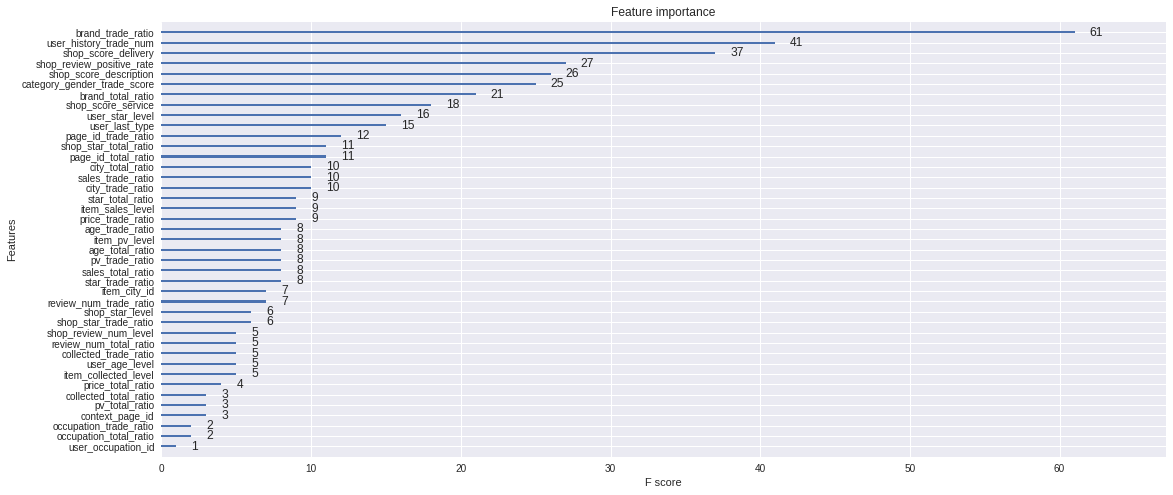

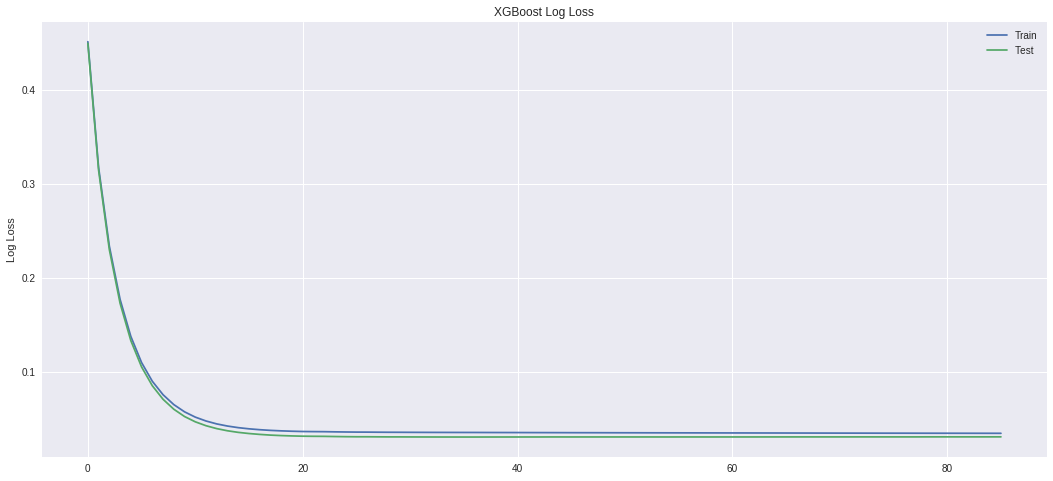

In [140]:
from matplotlib import pyplot 
from xgboost import plot_importance
#plot feature importance
ax = plot_importance(model,max_num_features=50)
fig = ax.figure
fig.set_size_inches(18, 8)
pyplot.show()

#plot logloss
epochs = len(eval_result['train']['logloss'])  
x_axis = range(0, epochs)  
fig, ax = pyplot.subplots()  
ax.plot(x_axis, eval_result['train']['logloss'], label='Train')  
ax.plot(x_axis, eval_result['test']['logloss'], label='Test')  
ax.legend()
fig = ax.figure
fig.set_size_inches(18, 8)
pyplot.ylabel('Log Loss')  
pyplot.title('XGBoost Log Loss')  
pyplot.show()